In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")

sns.set_style()

In [2]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')

In [3]:
paises = ['Mexico', 'Argentina', 'Ecuador', 'Chile', 'Spain']
df = dados[dados['Country/Region'].isin(paises)]
df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

## SARIMAX

##### Diferença entre os novos casos por dia

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

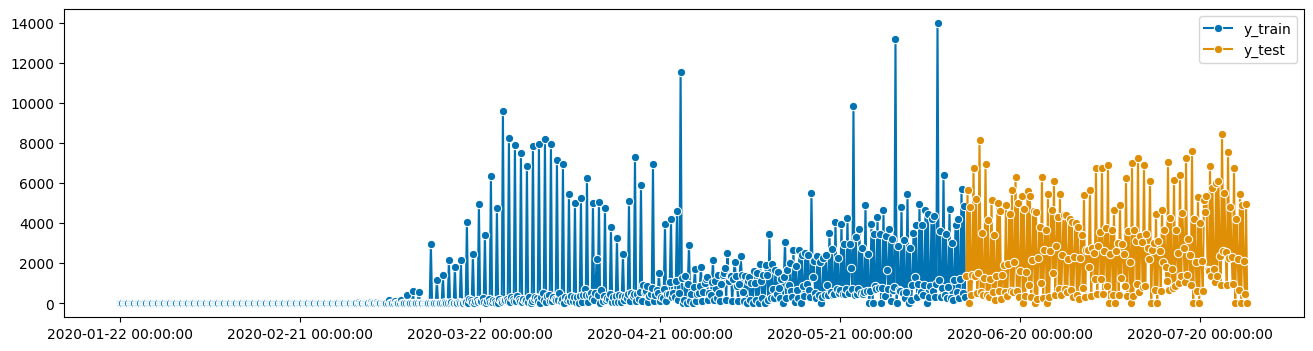

In [4]:
y = pd.Series(df['New cases'].values, df['Date'].values)
y_train, y_test = temporal_train_test_split(y)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

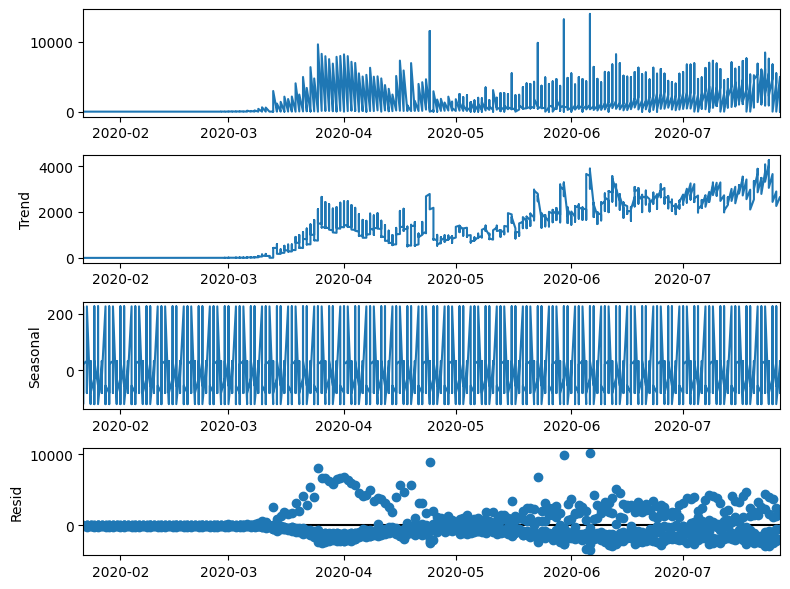

In [5]:
# decompor por semana
result = seasonal_decompose(y, model='additive', period=7)

fig = result.plot()
fig.set_size_inches((8, 6))

fig.tight_layout()
plt.show()

Foi utilizado a função seasonal_decompose da biblioteca stats models para dividir a série em três elementos: Tendência (trend), sazonalidade (seasonal) e resíduo (resid)

##### Aplicando a tecnica de SARIMAX na coluna 'New cases'

In [6]:
#!pip install pmdarima

In [7]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
novos_casos = df[['Date','New cases']].copy()

In [9]:
%%time

# criando o modelo
auto_arima(novos_casos['New cases'],seasonal=True,m=7).summary()

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(novos_casos['New cases'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=17519.376, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17696.018, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17164.382, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17694.018, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17170.874, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17084.491, Time=1.20 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=16930.207, Time=3.12 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17068.265, Time=0.64 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=16740.685, Time=3.20 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=16932.776, Time=3.67 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=16661.226, Time=5.20 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=17297.347, Time=2.87 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=17025.094, Time=3.20 sec
 ARIMA(0,1,1)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -7812.491
Date:                                Tue, 13 Dec 2022   AIC                          15648.981
Time:                                        17:25:59   BIC                          15707.119
Sample:                                             0   HQIC                         15671.145
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.067     -0.978      0.328      -0.198       0.066
ar.L2         -0.2108      0.036     -5.889      0.000      -0.281      -0.141
ar.L3         -0.1325      0.048     -2.785      0.005      -0.226      -0.039
ar.L4         -0.1369      0.054     -2.536      0.011      -0.243      -0.031
ar.L5          0.5595      0.039     14.221      0.000       0.482       0.637
ar.L6         -0.0750      0.061     -1.221      0.222      -0.195       0.045
ma.L1         -0.9501      0.022    -44.086      0.000      -0.992      -0.908
ar.S.L7        0.6284      0.032     19.671      0.000       0.566       0.691
ar.S.L14      -0.9396      0.026    -36.649      0.000      -0.990      -0.889
ma.S.L7       -0.5477      0.054    -10.208      0.000      -0.653      -0.443
ma.S.L14       0.7981      0.049     16.450      0.000       0.703       0.893
sigma2       1.12e+06   2.35e+04     47.665      0.000    1.07e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             54439.23
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
%%time

cut = int(novos_casos.shape[0] * 0.80)
train = novos_casos.iloc[:cut]
test = novos_casos.iloc[cut:]

# modelo
model = SARIMAX(train['New cases'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()
model_fit.summary()

CPU times: total: 6.16 s
Wall time: 10.7 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              New cases   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6279.807
Date:                                Tue, 13 Dec 2022   AIC                          12583.614
Time:                                        17:26:10   BIC                          12639.071
Sample:                                             0   HQIC                         12604.981
                                                - 752                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0849      0.095     -0.898      0.369      -0.270       0.100
ar.L2         -0.2033      0.047     -4.306      0.000      -0.296      -0.111
ar.L3         -0.1543      0.047     -3.269      0.001      -0.247      -0.062
ar.L4         -0.1724      0.064     -2.704      0.007      -0.297      -0.047
ar.L5          0.5757      0.047     12.264      0.000       0.484       0.668
ar.L6         -0.1119      0.090     -1.236      0.216      -0.289       0.066
ma.L1         -0.9442      0.029    -33.082      0.000      -1.000      -0.888
ar.S.L7        0.3266      0.055      5.989      0.000       0.220       0.434
ar.S.L14      -0.8679      0.059    -14.602      0.000      -0.984      -0.751
ma.S.L7       -0.1783      0.054     -3.313      0.001      -0.284      -0.073
ma.S.L14       0.9087      0.050     18.074      0.000       0.810       1.007
sigma2      1.229e+06   3.54e+04     34.734      0.000    1.16e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             41168.61
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):            1554.76   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

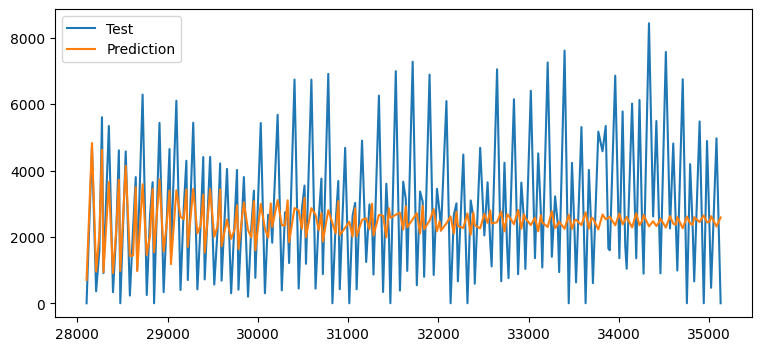

CPU times: total: 250 ms
Wall time: 503 ms


In [11]:
%%time

start = train.shape[0]
end   = novos_casos.shape[0] - 1

pred = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
pred.index = test.index

plt.figure(figsize=(14,10))
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

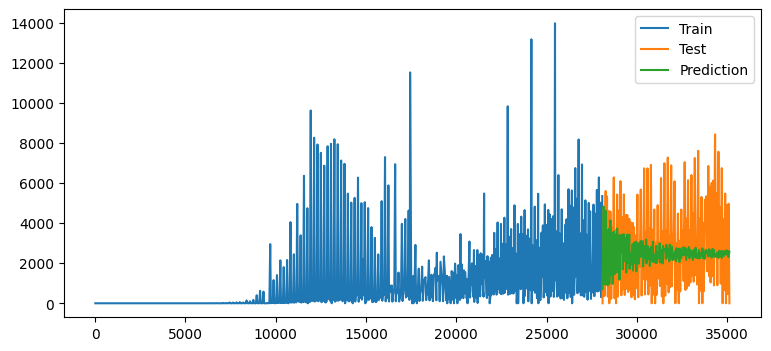

In [12]:
plt.figure(figsize=(14,10))
train['New cases'].plot(legend=True, label='Train')
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

In [13]:
print(f"R²   ---  {r2_score(test['New cases'], pred):.2f}")
print(f"MAE  ---  {mean_absolute_error(test['New cases'], pred):.2f}")
print(f"RMSE ---  {mean_squared_error(test['New cases'], pred, squared=False):.2f}")
print(f"MAPE ---  {mean_absolute_percentage_error(test['New cases'], pred)}")


R²   ---  0.10
MAE  ---  1598.92
RMSE ---  2034.90
MAPE ---  7.005516650594642e+17


### ADF

In [43]:
temp_test = train

In [44]:
temp_test.set_index('Date', inplace=True)

In [45]:
temp_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 752 entries, 2020-01-22 to 2020-06-20
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   New cases  752 non-null    int64
dtypes: int64(1)
memory usage: 11.8 KB


<AxesSubplot: xlabel='Date'>

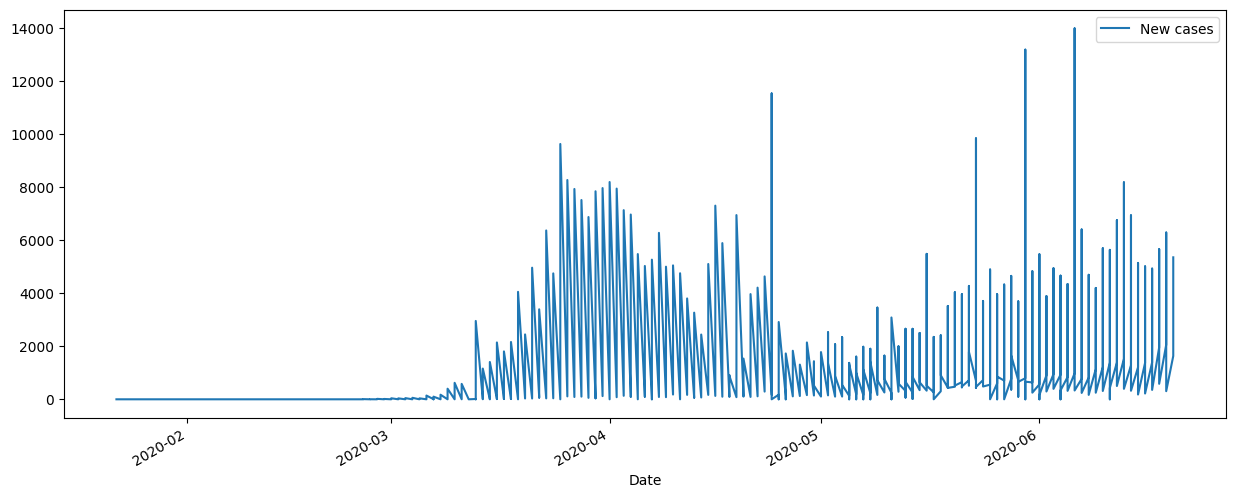

In [46]:
temp_test.plot(figsize=(15,6))

#### Periodo Quinzenal

In [52]:
quinzenal = temp_test.resample('15D').mean()
quinzenal.head()

,New cases
Date,
2020-01-22,0.013333
2020-02-06,0.013333
2020-02-21,5.760000
2020-03-07,352.626667
2020-03-22,1555.600000


#### Periodo Mensal

In [53]:
mensal = temp_test.resample('1M').mean()
mensal.head()

,New cases
Date,
2020-01-31,0.000000
2020-02-29,0.351724
2020-03-31,665.967742
2020-04-30,1243.206667
2020-05-31,1505.832258


### Analise de tendencia

In [59]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
rolling_mean = temp_test.rolling(window=indexer, min_periods=2).mean()
rolling_mean = rolling_mean.shift(2) # deslocamento da janela = 2 meses
rolling_mean

,New cases
Date,
2020-01-22,NaN
2020-01-22,NaN
2020-01-22,0.0
2020-01-22,0.0
2020-01-22,0.0
...,...
2020-06-19,4175.0
2020-06-19,3462.0
2020-06-19,2832.0


### Analise de sazionalidade

<AxesSubplot: xlabel='Date'>

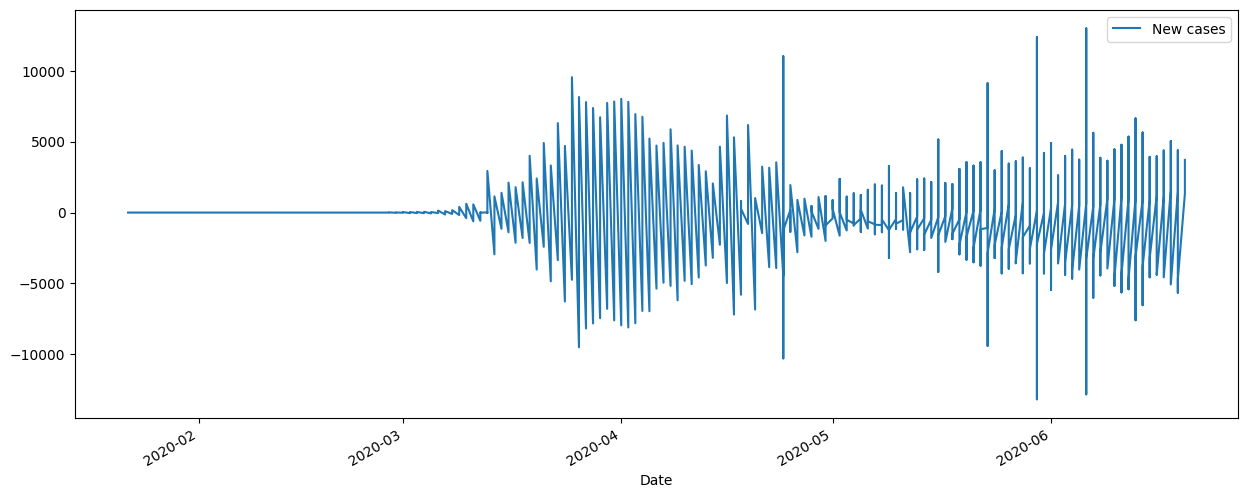

In [60]:
temp_test.diff().plot(figsize=(15,6))

In [61]:
# criando filtros para analiser melhor o grafico
filtro = (temp_test.index.month >= 3) & (temp_test.index.month <=6)

<AxesSubplot: xlabel='Date'>

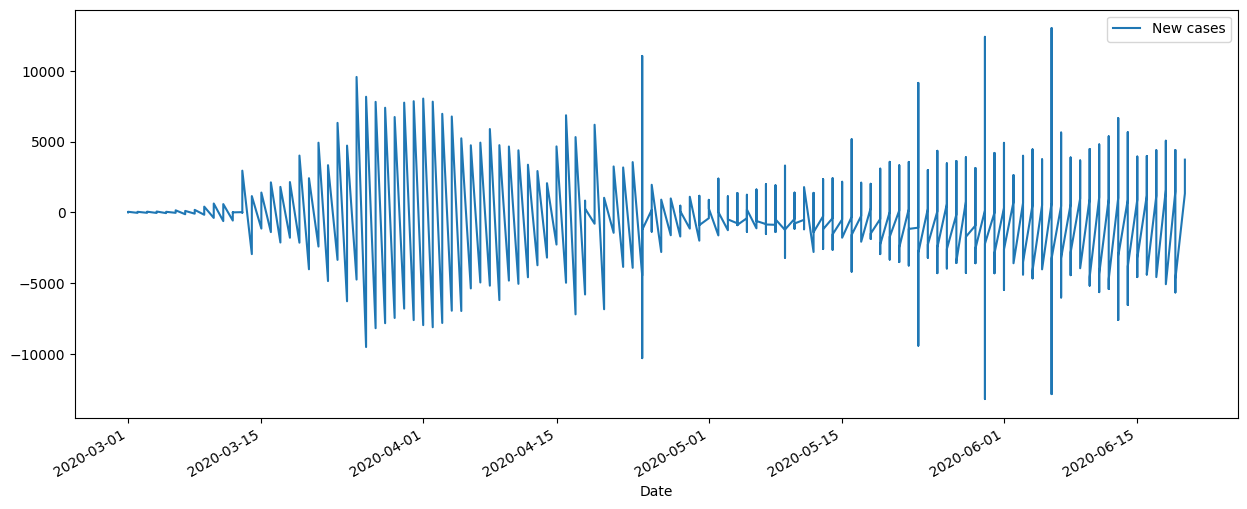

In [63]:
temp_test[filtro].diff().plot(figsize=(15,6))

Os picos se manifestam proximos ao inicio do mês e tbm parece aparecerem quinzenalmente.

#### Analise de tendencia (6 meses)

In [70]:
# função para plotar uma serie e sua média movel 3 meses

def plot_mediamovel(timeseries):
    
    rolmean = timeseries.rolling(6).mean()
    
    
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Média movel 6 meses')
    plt.legend(loc='best')
    plt.title('Valor original e média movel dos 6 meses')
    plt.show(block=False)

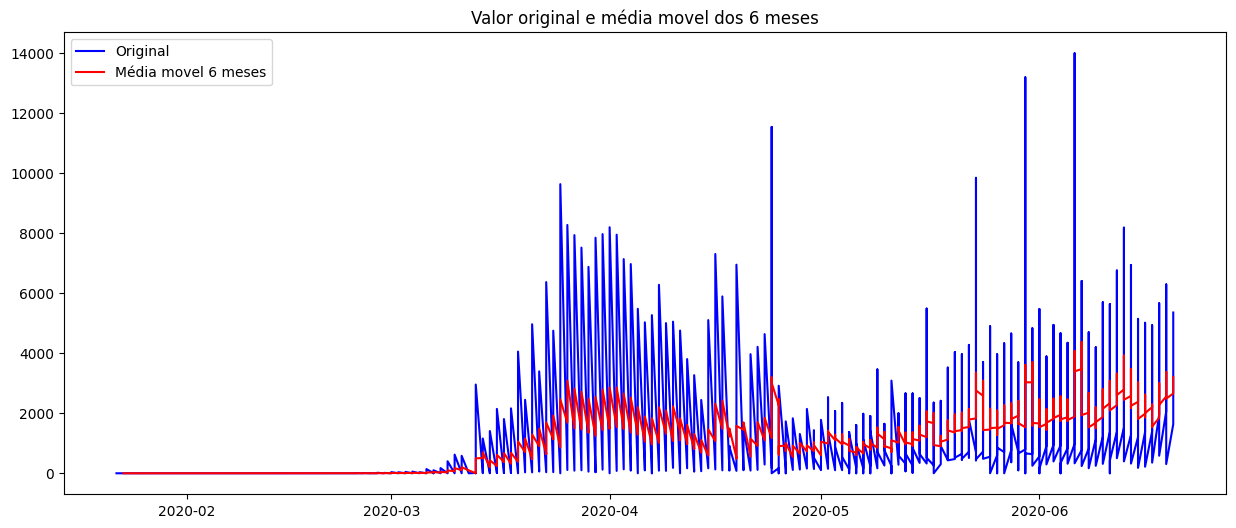

In [71]:
plot_mediamovel(temp_test)

In [21]:
from statsmodels.tsa.stattools import adfuller

ADF Statistic: -2.919798110234366
p-value: 0.04309371074331277
                                       SARIMAX Results                                        
Dep. Variable:                              New cases   No. Observations:                  188
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1520.350
Date:                                Tue, 13 Dec 2022   AIC                           3064.700
Time:                                        18:46:08   BIC                           3103.473
Sample:                                             0   HQIC                          3080.411
                                                - 188                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.00

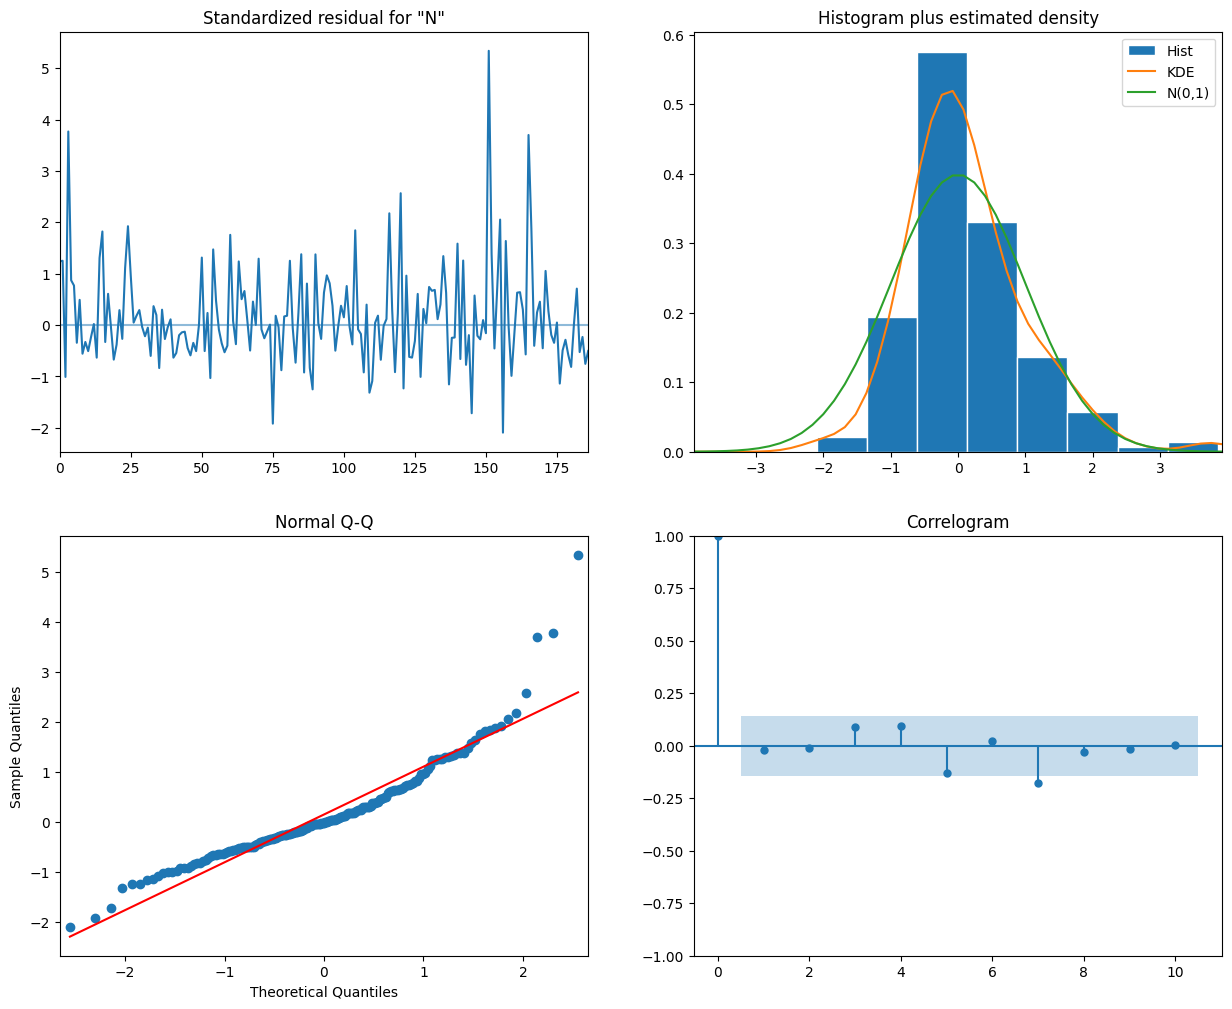

<Figure size 640x480 with 0 Axes>

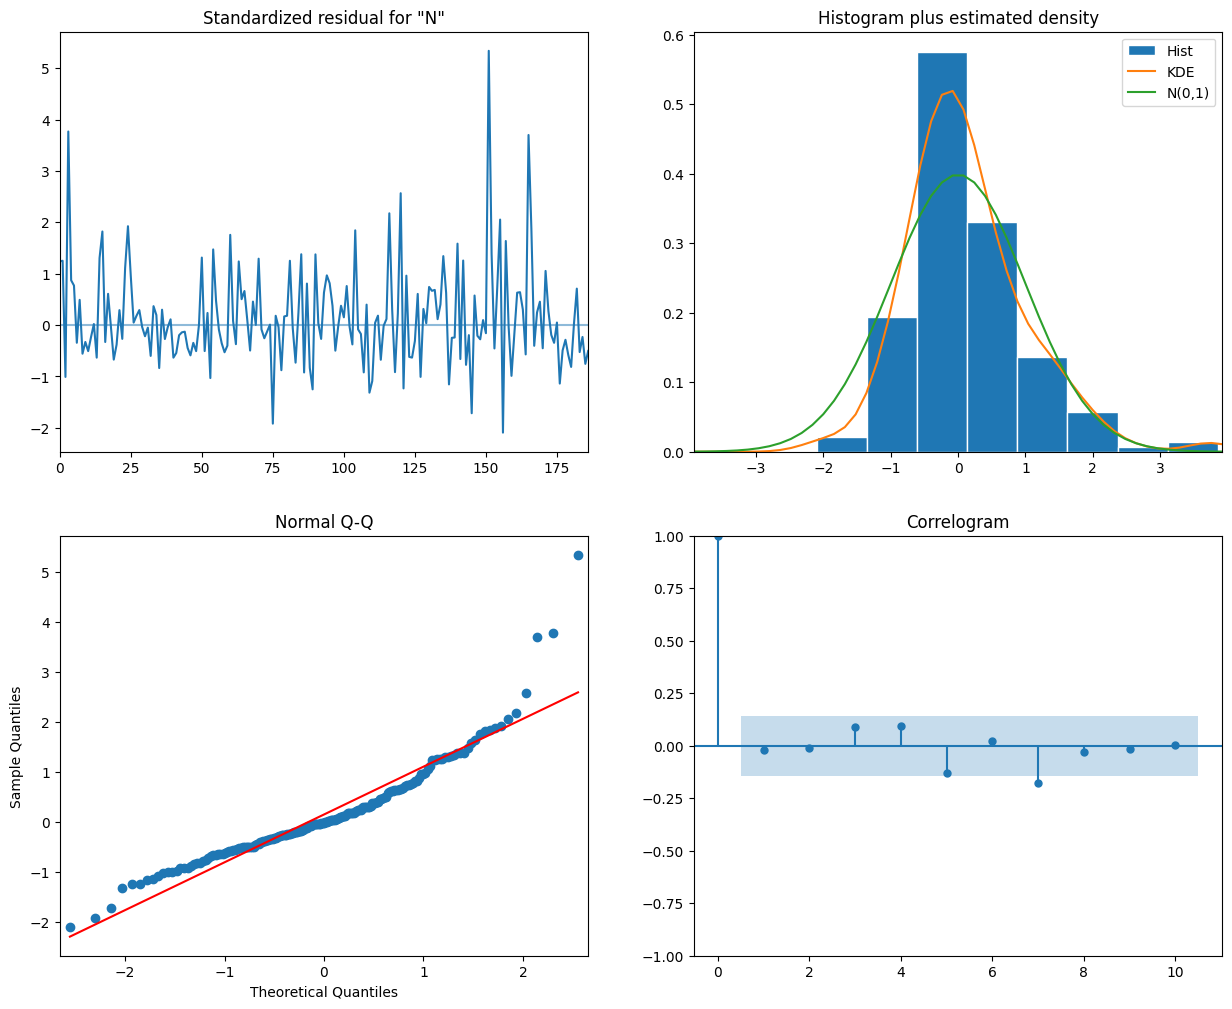

In [37]:
#x = organic_search.groupby('Week_Start_Date').Amount.sum()

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(temp_test)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# SARIMA Model
plt.figure(2)
#best_model = SARIMAX(test['New cases'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 52)).fit(dis=1)
best_model = SARIMAX(temp_test,order=(6,1,1),seasonal_order=(2,0,[1,2],7)).fit(dis=1)
#best_model = SARIMAX(test['New cases'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 52)).fit(dis=1)
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))

## Modelo ThetaForecaster

In [14]:
#from xgboost import XGBRegressor

from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import MeanAsymmetricError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
#from sktime.performance_metrics.forecasting import smape_loss

In [15]:
%%time

y_train, y_test = temporal_train_test_split(y)
fh = np.arange(1, len(y_test) + 1)  
forecaster = ThetaForecaster(sp=12, deseasonalize=False)  
forecaster.fit(y_train.values)
y_pred = forecaster.predict(fh)
#smape_loss(y_test, y_pred) #0.08661469103230263
#MeanAbsolutePercentageError(y_test, y_pred)

CPU times: total: 15.6 ms
Wall time: 186 ms


Erro Médio Absoluto (MAE), que é a média dos erros absolutos (ignorando o sinal positivo ou negativo). Assim sabemos melhor quanto estamos desviando dos valores reais nas unidades originais.

Erro Percentual Absoluto Médio (MAPE). É uma métrica bastante utilizada na área de previsões de séries temporais, e se refere à média do percentual de erros cometidos nas previsões, desconsiderando a direção (acima ou abaixo do real).

In [16]:
print(f"R²   ---  {r2_score(y_test, y_pred):.2f}")
print(f"MAE  ---  {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE ---  {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"MAPE ---  {mean_absolute_percentage_error(y_test, y_pred)}")


R²   ---  -0.01
MAE  ---  1827.85
RMSE ---  2187.61
MAPE ---  6.731194031802877e+17
